Original Codes from :  
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6  
https://tykimos.github.io/2017/06/10/CNN_Data_Augmentation/

In [1]:
import sys
print(sys.executable)

E:\Anaconda3\envs\tensorflowgpu\python.exe


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from IPython.display import clear_output
%matplotlib inline

import tensorflow as tf
import tensorflow_addons as tfa

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))
print(tf.config.list_physical_devices('GPU'))

tensorflow version: 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU 사용 가능 여부: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_pandas = pd.read_csv("./input/train.csv")
test_pandas = pd.read_csv("./input/test.csv")

In [4]:
train_label = train_pandas["label"]
train_data = train_pandas.drop(["label"],axis=1)
test_data = test_pandas

In [5]:
print(train_data)

       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995       0       0       0       0       0       0       0       0       0   
41996       0       0       0       0       0       0       0       0       0   
41997       0       0       0       0       0       0       0       0       0   
41998       0       0       0       0       0       0       0       0       0   
41999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel77

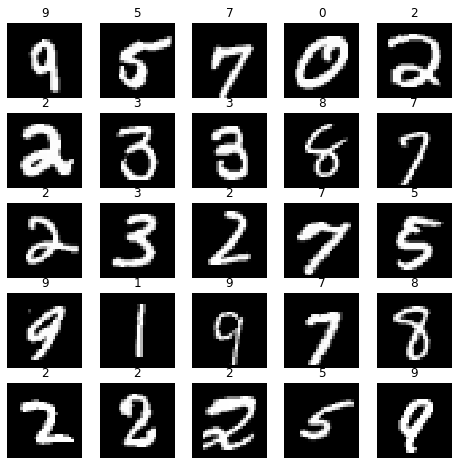

In [6]:
labels_map = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
              5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8, 8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data.values))
    img = train_data.values[data_idx].reshape([28, 28])
    label = labels_map[train_label[data_idx]]

    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.1, random_state=1)

In [8]:
batch_size = 20
max_epochs = 20
learning_rate = 1e-4
num_classes = 10
batch_size = 128

In [9]:
def normalize_image(input_image):
    input_image = (input_image / 255)

    return input_image

In [10]:
def reshape_image(input_image):
    return input_image.values.reshape(-1,28,28,1)

In [11]:
train_data = normalize_image(train_data)
train_data = reshape_image(train_data)
val_data = normalize_image(val_data)
val_data = reshape_image(val_data)
test_data = normalize_image(test_data)
test_data = reshape_image(test_data)

train_label = train_label.values
val_label = val_label.values

In [12]:
train_label = tf.one_hot(train_label,num_classes)
val_label = tf.one_hot(val_label,num_classes)

In [13]:
print(train_data[0].shape)

(28, 28, 1)


In [14]:
random_list = [np.random.randint(len(train_data)) for r in range(25)]

https://www.tensorflow.org/guide/data#consuming_python_generators

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [15]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [16]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        ## 코드 시작 ##
        self.conv = tf.keras.layers.Conv2D(filters=num_filters,kernel_size=[kernel_size, kernel_size],padding='Same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.dropout = tf.keras.layers.Dropout(0.25)
        ## 코드 종료 ##

    def call(self, inputs, training=True):
        ## 코드 시작 ##
        x = self.conv(inputs)    # self.conv forward
        x = self.bn(x)    # self.bn   forward
        x = self.relu(x)    # self.relu forward
        x = self.pool(x)    # self.pool forward
        x = self.dropout(x)
        ## 코드 종료 ##

        return x

In [17]:
class SimpleCNN(tf.keras.Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        ## 코드 시작 ##
        self.conv1 = Conv(32,5)
        self.conv2 = Conv(64,3)

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=256,activation=tf.nn.relu)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.dense2 = tf.keras.layers.Dense(units=num_classes,activation=tf.nn.softmax)
        ## 코드 종료 ##

    def call(self, inputs, training=True):
        ## 코드 시작 ##
        x = self.conv1(inputs)    # self.conv1 forward
        x = self.conv2(x)    # self.conv2 forward
        x = self.flatten(x)    # flatten 
        x = self.dense1(x)    # self.dense1 forward
        x = self.dropout(x)
        x = self.dense2(x)    # self.dense2 forward
        ## 코드 종료 ##

        return x

In [18]:
train_dir = os.path.join('./train/exp2')
print_steps = 25
val_epoch = 1

In [19]:
# Define the optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [20]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
model = SimpleCNN()

In [22]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator

In [23]:
history = model.fit_generator(
        datagen.flow(train_data,train_label, batch_size=batch_size),
        steps_per_epoch=train_data.shape[0] // batch_size,
        epochs=max_epochs,
        validation_data=(val_data,val_label),
        validation_steps=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 295 steps, validate on 4200 samples
Epoch 1/20
295/295 [==============================] - 10s 33ms/step - loss: 0.7993 - accuracy: 0.7793 - val_loss: 0.2043 - val_accuracy: 0.5344
Epoch 2/20
295/295 [==============================] - 8s 26ms/step - loss: 0.2005 - accuracy: 0.9373 - val_loss: 0.0178 - val_accuracy: 0.9672
Epoch 3/20
295/295 [==============================] - 8s 26ms/step - loss: 0.1515 - accuracy: 0.9534 - val_loss: 0.0122 - val_accuracy: 0.9844
Epoch 4/20
295/295 [==============================] - 8s 26ms/step - loss: 0.1342 - accuracy: 0.9605 - val_loss: 0.0112 - val_accuracy: 0.9812
Epoch 5/20
295/295 [==============================] - 7s 25ms/step - loss: 0.1128 - accuracy: 0.9660 - val_loss: 0.0130 - val_accuracy: 0.9766
Epoch 6/20
295/295 [==============================] - 8s 25ms/step - loss: 0.1038 - accuracy: 0.9686 - val_loss: 0.0095 - val_accuracy: 0.9828
Epoch 7/20
295/295 

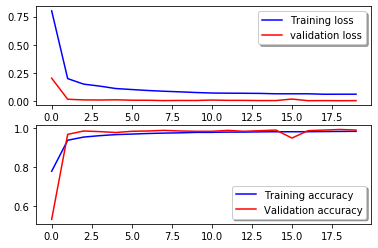

In [24]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [25]:
print(val_data.shape)

(4200, 28, 28, 1)


In [26]:
print(val_data[1][:,:,0].shape)

(28, 28)


In [28]:
val_label_num = np.argmax(val_label, axis=1).reshape(-1,1)

[ 660  634  573 1697 1411 1684 1461 1173 2621 1517 3163 2835 2435  127
 3848 1283  982 3745  506 2547 1325  207  527  682   85]
(25, 28, 28, 1)
(25, 1)


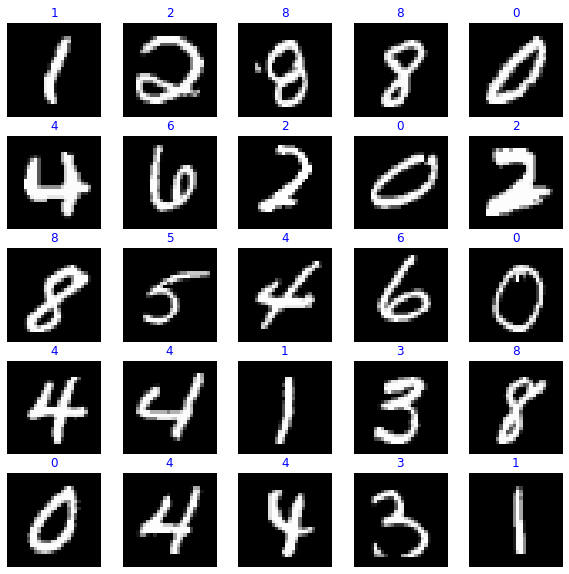

In [30]:
test_batch_size = 25
batch_index = np.random.choice(
    len(val_data), size=test_batch_size, replace=False)

print(batch_index)

batch_xs = val_data[batch_index]
batch_ys = val_label_num[batch_index]
y_pred_ = model(batch_xs, training=False)

print(batch_xs.shape)
print(batch_ys.shape)

fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(batch_xs, batch_ys, y_pred_)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred) == py:
        p.set_title("{}".format(labels_map[py[0]]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred)],
                                   labels_map[py[0]]), color='red')
    p.imshow(px[:,:,0], cmap="gray")
    p.axis('off')

In [31]:
test_datasetd = tf.data.Dataset.from_tensor_slices(test_data)
test_datasetd = test_datasetd.batch(batch_size)

In [32]:
def test(model, test_dataonly):
    print('Start test..')
    predictions = []
    
    tmp_list = []

    for images in test_dataonly:
        predictions = np.append(predictions, np.argmax(model(images), axis=1)).astype(int)
        
    print("test done...")
    
    return predictions

In [33]:
predictions = test(model,test_datasetd)

Start test..
test done...


In [34]:
predictions.shape

(28000,)

In [35]:
results = pd.Series(predictions,name="Label")

In [36]:
results

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int32

In [37]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)